# Laboratorio #4

**Esteban Zambrano - 22119**<br>
**Andrés Ortega - 22305**<br>
**Diego García - 22404**

In [6]:
#!pip install openeo
#!pip install rasterio

In [5]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import openeo
import glob
import os
import re
import pandas as pd
import warnings

from datetime import date
from pathlib import Path

In [8]:
connection = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


In [2]:
#Areas de interes
lago_atitlan = {
    "west": -91.349,
    "east": -91.0702,
    "south": 14.5971,
    "north": 14.7648
}
lago_amatitlan = {
    "west": -90.66,
    "east": -90.58,
    "south": 14.43,
    "north": 14.51
}

bands_needed = ["B02","B03","B04","B05","B07","B08","B8A","B11","B12"]

In [3]:
# Código de https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/cyanobacteria_chla_ndci_l1c/#representative-images pasado a python

# Water body detection - credit Mohor Gartner
MNDWI_threshold = 0.42
NDWI_threshold = 0.4
filter_UABS = True
filter_SSI = False

def wbi(r, g, b, nir, swir1, swir2):
    # water surface
    ws = 0
    try:
        # Calc indices
        ndvi = (nir - r) / (nir + r)
        mndwi = (g - swir1) / (g + swir1)
        ndwi = (g - nir) / (g + nir)
        ndwi_leaves = (nir - swir1) / (nir + swir1)
        aweish = b + 2.5 * g - 1.5 * (nir + swir1) - 0.25 * swir2
        aweinsh = 4 * (g - swir1) - (0.25 * nir + 2.75 * swir1)

        dbsi = ((swir1 - g) / (swir1 + g)) - ndvi
        wii = np.power(nir, 2) / r
        wri = (g + r) / (nir + swir1)
        puwi = 5.83 * g - 6.57 * r - 30.32 * nir + 2.25
        uwi = (g - 1.1 * r - 5.2 * nir + 0.4) / np.abs(g - 1.1 * r - 5.2 * nir)
        usi = 0.25 * (g / r) - 0.57 * (nir / g) - 0.83 * (b / g) + 1

        if (mndwi > MNDWI_threshold or ndwi > NDWI_threshold or
            aweinsh > 0.1879 or aweish > 0.1112 or
            ndvi < -0.2 or ndwi_leaves > 1):
            ws = 1

        if filter_UABS and ws == 1:
            if (aweinsh <= -0.03) or (dbsi > 0):
                ws = 0

    except Exception:
        ws = 0
    return ws

# Floating vegetation
def FAI(a, b, c):
    return b - a - (c - a) * (783 - 665) / (865 - 665)

# Chlorophyll-a
def NDCI(a, b):
    return (b - a) / (b + a)

def classify_pixel(B02, B03, B04, B05, B07, B08, B8A, B11, B12):
    water = wbi(B04, B03, B02, B08, B11, B12)
    FAIv = FAI(B04, B07, B8A)
    NDCIv = NDCI(B04, B05)
    chl = 826.57 * NDCIv**3 - 176.43 * NDCIv**2 + 19 * NDCIv + 4.071

    trueColor = [3 * B04, 3 * B03, 3 * B02]

    #  Render colour map
    if water == 0:
        return trueColor
    elif FAIv > 0.08:
        return [233/255, 72/255, 21/255]
    elif chl < 0.5:
        return [0, 0, 1.0]
    elif chl < 1:
        return [0, 0, 1.0]
    elif chl < 2.5:
        return [0, 59/255, 1]
    elif chl < 3.5:
        return [0, 98/255, 1]
    elif chl < 5:
        return [15/255, 113/255, 141/255]
    elif chl < 7:
        return [14/255, 141/255, 120/255]
    elif chl < 8:
        return [13/255, 141/255, 103/255]
    elif chl < 10:
        return [30/255, 226/255, 28/255]
    elif chl < 14:
        return [42/255, 226/255, 28/255]
    elif chl < 18:
        return [68/255, 226/255, 28/255]
    elif chl < 20:
        return [68/255, 226/255, 28/255]
    elif chl < 24:
        return [134/255, 247/255, 0]
    elif chl < 28:
        return [140/255, 247/255, 0]
    elif chl < 30:
        return [205/255, 237/255, 0]
    elif chl < 38:
        return [208/255, 240/255, 0]
    elif chl < 45:
        return [208/255, 240/255, 0]
    elif chl < 50:
        return [251/255, 210/255, 3/255]
    elif chl < 75:
        return [248/255, 207/255, 2/255]
    elif chl < 90:
        return [134/255, 247/255, 0]
    elif chl < 100:
        return [245/255, 164/255, 9/255]
    elif chl < 150:
        return [240/255, 159/255, 8/255]
    elif chl < 250:
        return [237/255, 157/255, 7/255]
    elif chl < 300:
        return [239/255, 118/255, 15/255]
    elif chl < 350:
        return [239/255, 101/255, 15/255]
    elif chl < 450:
        return [239/255, 100/255, 14/255]
    elif chl < 500:
        return [233/255, 72/255, 21/255]
    else:
        return [233/255, 72/255, 21/255]

In [4]:
def download_lake(spatial_extent, output_path):
    cube = connection.load_collection(
        "SENTINEL2_L2A",
        spatial_extent=spatial_extent,
        temporal_extent=["2025-02-01", "2025-07-31"],
        bands=bands_needed,
        max_cloud_cover=20
    )
    
    # Guardar resultado temporal en GeoTIFF
    temp_result = cube.save_result(format="GTIFF")
    job = connection.create_job(temp_result)
    job.start_and_wait()
    job.download_results(output_path)


def process_image(input_tif, output_tif):
    with rasterio.open(input_tif) as src:
        bands_data = src.read()
        transform = src.transform
        crs = src.crs
    
    # Extraer bandas por nombre
    B02, B03, B04, B05, B07, B08, B8A, B11, B12 = bands_data
    
    # Salida con 3 canales RGB
    rgb = np.zeros((3, B02.shape[0], B02.shape[1]), dtype=np.float32)
    
    for i in range(B02.shape[0]):
        for j in range(B02.shape[1]):
            rgb_pixel = classify_pixel(
                B02[i, j], B03[i, j], B04[i, j], B05[i, j],
                B07[i, j], B08[i, j], B8A[i, j], B11[i, j], B12[i, j]
            )
            rgb[:, i, j] = rgb_pixel
    
    # Guardar resultado
    with rasterio.open(
        output_tif,
        "w",
        driver="GTiff",
        height=rgb.shape[1],
        width=rgb.shape[2],
        count=3,
        dtype=rgb.dtype,
        crs=crs,
        transform=transform
    ) as dst:
        dst.write(rgb[0], 1)
        dst.write(rgb[1], 2)
        dst.write(rgb[2], 3)

In [13]:
# Descargar imagenes de los lagos

# download_lake(lago_atitlan, "../data/imgsAti")
download_lake(lago_amatitlan, "../data/imgsAmati")

0:00:00 Job 'j-2508140616094aeab545825e9c041a06': send 'start'
0:00:13 Job 'j-2508140616094aeab545825e9c041a06': created (progress 0%)
0:00:18 Job 'j-2508140616094aeab545825e9c041a06': created (progress 0%)
0:00:25 Job 'j-2508140616094aeab545825e9c041a06': created (progress 0%)
0:00:33 Job 'j-2508140616094aeab545825e9c041a06': created (progress 0%)
0:00:43 Job 'j-2508140616094aeab545825e9c041a06': created (progress 0%)
0:00:55 Job 'j-2508140616094aeab545825e9c041a06': created (progress 0%)
0:01:11 Job 'j-2508140616094aeab545825e9c041a06': running (progress N/A)
0:01:30 Job 'j-2508140616094aeab545825e9c041a06': running (progress N/A)
0:01:55 Job 'j-2508140616094aeab545825e9c041a06': running (progress N/A)
0:02:26 Job 'j-2508140616094aeab545825e9c041a06': running (progress N/A)
0:03:03 Job 'j-2508140616094aeab545825e9c041a06': running (progress N/A)
0:03:50 Job 'j-2508140616094aeab545825e9c041a06': running (progress N/A)
0:04:48 Job 'j-2508140616094aeab545825e9c041a06': finished (progres

C:\Users\dgv31\AppData\Local\Temp\ipykernel_26224\4160958946.py:14: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(output_path)


In [16]:
# Procesar las imágenes descargadas según el script de sentinel-hub

file_ati = glob.glob(os.path.join("../data/imgsAti/", "openEO_*.tif"))[0]
file_amati = glob.glob(os.path.join("../data/imgsAmati/", "openEO_*.tif"))[0]

print("Archivo encontrado Ati:", file_ati)
print("Archivo encontrado Amati:", file_amati)

# Procesar usando tus funciones
for tif_file in glob.glob(os.path.join("../data/imgsAti/", "openEO_*.tif")):
    date = os.path.basename(tif_file).split("_")[1]  # Extrae "2025-03-07"
    output_name = f"../data/cyanobacAti/chl_Atitlan_{date}.tif"
    process_image(tif_file, output_name)

for tif_file in glob.glob(os.path.join("../data/imgsAmati/", "openEO_*.tif")):
    date = os.path.basename(tif_file).split("_")[1]  # Extrae "2025-03-07"
    output_name = f"../data/cyanobacAmati/chl_Amatitlan_{date}.tif"
    process_image(tif_file, output_name)

Archivo encontrado Ati: ../data/imgsAti\openEO_2025-02-07Z.tif
Archivo encontrado Amati: ../data/imgsAmati\openEO_2025-02-02Z.tif


C:\Users\dgv31\AppData\Local\Temp\ipykernel_26224\1061942483.py:43: RuntimeWarning: overflow encountered in scalar multiply
  return b - a - (c - a) * (783 - 665) / (865 - 665)
C:\Users\dgv31\AppData\Local\Temp\ipykernel_26224\1061942483.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  wii = np.power(nir, 2) / r
C:\Users\dgv31\AppData\Local\Temp\ipykernel_26224\1061942483.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  usi = 0.25 * (g / r) - 0.57 * (nir / g) - 0.83 * (b / g) + 1
C:\Users\dgv31\AppData\Local\Temp\ipykernel_26224\1061942483.py:26: RuntimeWarning: invalid value encountered in scalar subtract
  usi = 0.25 * (g / r) - 0.57 * (nir / g) - 0.83 * (b / g) + 1
C:\Users\dgv31\AppData\Local\Temp\ipykernel_26224\1061942483.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  return (b - a) / (b + a)
C:\Users\dgv31\AppData\Local\Temp\ipykernel_26224\1061942483.py:53: RuntimeWarning: invalid value encountered in scalar subtract

### Conviersión de arreglos a numpy 

In [24]:
# Extracción numérica (sin loops por píxel)

warnings.filterwarnings("ignore", category=RuntimeWarning)

def compute_indices_arrays(B02, B03, B04, B05, B07, B08, B8A, B11, B12,
                           mndwi_thr=0.42, ndwi_thr=0.40, filter_UABS=True):
    # Índices con divisiones seguras
    ndvi        = _safe_div(B08 - B04, B08 + B04)
    mndwi       = _safe_div(B03 - B11, B03 + B11)
    ndwi        = _safe_div(B03 - B08, B03 + B08)
    ndwi_leaves = _safe_div(B08 - B11, B08 + B11)

    aweish  = B02 + 2.5*B03 - 1.5*(B08 + B11) - 0.25*B12
    aweinsh = 4*(B03 - B11) - (0.25*B08 + 2.75*B11)
    dbsi    = _safe_div(B11 - B03, B11 + B03) - ndvi

    # Umbrales pensados para reflectancia 0–1
    ws = (
        (mndwi > mndwi_thr) |
        (ndwi >  ndwi_thr)  |
        (aweinsh > 0.1879)  |
        (aweish  > 0.1112)  |
        (ndvi <  -0.2)      |
        (ndwi_leaves > 1)
    )
    ws = np.where(np.isnan(ws), False, ws)

    if filter_UABS:
        ws = ws & ~((aweinsh <= -0.03) | (dbsi > 0))

    # FAI, NDCI y clorofila
    FAI  = B8A - B04 - (B07 - B04) * (783 - 665) / (865 - 665 + 1e-6)
    NDCI = _safe_div(B05 - B04, B05 + B04)

    chl = 826.57*(NDCI**3) - 176.43*(NDCI**2) + 19*NDCI + 4.071

    chl = np.where(ws, chl, np.nan)
    chl = np.where(np.isfinite(chl), chl, np.nan)
    chl = np.where((chl < -5) | (chl > 300), np.nan, chl)

    return ws.astype(np.uint8), FAI, NDCI, chl

def read_s2_stack(path):
    with rasterio.open(path) as src:
        arr = src.read().astype(np.float32)
        transform, crs = src.transform, src.crs
        nodata = src.nodata

    if nodata is not None:
        arr = np.where(arr == nodata, np.nan, arr)

    p99 = np.nanpercentile(arr, 99)
    if p99 > 1.5:   # heurística robusta
        arr = arr / 10000.0

    # Recortar valores por ruido
    arr = np.clip(arr, 0.0, 1.2)

    B02, B03, B04, B05, B07, B08, B8A, B11, B12 = arr
    return (B02, B03, B04, B05, B07, B08, B8A, B11, B12), transform, crs

def _safe_div(num, den, eps=1e-6):
    den_ok = np.where(np.abs(den) > eps, den, np.nan)
    return num / den_ok

def write_singleband(path_out, array, transform, crs, dtype="float32", nodata_val=np.nan):
    profile = {
        "driver": "GTiff",
        "height": array.shape[0],
        "width":  array.shape[1],
        "count": 1,
        "dtype": dtype,
        "crs": crs,
        "transform": transform,
        "compress": "lzw"
    }
    with rasterio.open(path_out, "w", **profile) as dst:
        dst.write(array.astype(dtype), 1)

In [25]:
# Generación de rásters numéricos (clorofila-a) por lago

def extract_date_from_name(fname):
    # busca YYYY-MM-DD en el nombre
    m = re.search(r"(20\d{2}-\d{2}-\d{2})", os.path.basename(fname))
    return m.group(1) if m else "unknown"

def make_chla_rasters(img_dir, out_dir, lake_tag, overwrite=False):
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    files = sorted(glob.glob(os.path.join(img_dir, "openEO_*.tif")))
    outputs = []
    for tif in files:
        date_tag = re.search(r"(20\d{2}-\d{2}-\d{2})", os.path.basename(tif)).group(1)
        out_tif = os.path.join(out_dir, f"chla_{lake_tag}_{date_tag}.tif")
        if (not overwrite) and os.path.exists(out_tif):
            outputs.append(out_tif); print("Saltado:", os.path.basename(out_tif)); continue
        (B02,B03,B04,B05,B07,B08,B8A,B11,B12), transform, crs = read_s2_stack(tif)
        _, _, _, chl = compute_indices_arrays(B02,B03,B04,B05,B07,B08,B8A,B11,B12)
        with rasterio.open(
            out_tif, "w", driver="GTiff", height=chl.shape[0], width=chl.shape[1],
            count=1, dtype="float32", crs=crs, transform=transform, compress="lzw"
        ) as dst:
            dst.write(chl.astype("float32"), 1)
        outputs.append(out_tif)
        print("Guardado:", os.path.basename(out_tif))
    return outputs

outs_ati = make_chla_rasters("../data/imgsAti",   "../data/cyanobacAti_num",   "Atitlan",    overwrite=True)
outs_am  = make_chla_rasters("../data/imgsAmati", "../data/cyanobacAmati_num", "Amatitlan",  overwrite=True)


Guardado: chla_Atitlan_2025-02-07.tif
Guardado: chla_Atitlan_2025-02-25.tif
Guardado: chla_Atitlan_2025-02-27.tif
Guardado: chla_Atitlan_2025-03-02.tif
Guardado: chla_Atitlan_2025-03-04.tif
Guardado: chla_Atitlan_2025-03-07.tif
Guardado: chla_Atitlan_2025-03-09.tif
Guardado: chla_Atitlan_2025-03-12.tif
Guardado: chla_Atitlan_2025-03-14.tif
Guardado: chla_Atitlan_2025-03-22.tif
Guardado: chla_Atitlan_2025-03-24.tif
Guardado: chla_Atitlan_2025-04-03.tif
Guardado: chla_Atitlan_2025-04-11.tif
Guardado: chla_Atitlan_2025-04-13.tif
Guardado: chla_Atitlan_2025-04-15.tif
Guardado: chla_Atitlan_2025-04-16.tif
Guardado: chla_Atitlan_2025-04-18.tif
Guardado: chla_Atitlan_2025-04-28.tif
Guardado: chla_Atitlan_2025-05-03.tif
Guardado: chla_Atitlan_2025-05-13.tif
Guardado: chla_Atitlan_2025-07-10.tif
Guardado: chla_Atitlan_2025-07-17.tif
Guardado: chla_Atitlan_2025-07-20.tif
Guardado: chla_Amatitlan_2025-02-02.tif
Guardado: chla_Amatitlan_2025-02-07.tif
Guardado: chla_Amatitlan_2025-02-12.tif
Guarda

In [28]:
# Estadísticos por fecha

def summarize_chla(tif_list, lake):
    rows = []
    for tif in sorted(tif_list):
        date_tag = extract_date_from_name(tif)
        with rasterio.open(tif) as src:
            a = src.read(1).astype(np.float32)
        # Cobertura proporción de pixeles con dato
        finite = np.isfinite(a)
        coverage = finite.mean() if finite.size else 0.0
        if coverage == 0:
            mean = median = std = q10 = q50 = q90 = np.nan
            minv = maxv = np.nan
        else:
            vals = a[finite]
            mean   = float(np.nanmean(vals))
            median = float(np.nanmedian(vals))
            std    = float(np.nanstd(vals))
            q10, q50, q90 = [float(np.nanpercentile(vals, p)) for p in (10, 50, 90)]
            minv, maxv    = float(np.nanmin(vals)), float(np.nanmax(vals))
        rows.append({
            "lake": lake, "date": date_tag,
            "mean_chla": mean, "median": median, "std": std,
            "p10": q10, "p50": q50, "p90": q90,
            "min": minv, "max": maxv, "coverage": coverage
        })
    return pd.DataFrame(rows).sort_values(["date"])

df_ati = summarize_chla(outs_ati, "Atitlan")
df_am  = summarize_chla(outs_am,  "Amatitlan")

summary = pd.concat([df_ati, df_am], ignore_index=True)
summary.to_csv("../data/summary_point5.csv", index=False)
summary.head()


,lake,date,mean_chla,median,std,p10,p50,p90,min,max,coverage
0,Atitlan,2025-02-07,11.993536,4.813330,29.335297,0.407569,4.813330,21.414707,-4.996635,293.195007,0.101445
1,Atitlan,2025-02-25,3.722998,3.981339,2.054187,2.436786,3.981339,4.563935,-4.996631,244.598007,0.038985
2,Atitlan,2025-02-27,3.348401,3.621939,1.178722,2.045308,3.621939,4.398536,-4.999456,62.751328,0.227094
3,Atitlan,2025-03-02,4.640402,4.071000,11.578427,-1.089426,4.071000,6.239658,-4.990739,298.819946,0.017764
4,Atitlan,2025-03-04,3.186064,3.598156,1.450153,1.493005,3.598156,4.388079,-4.998645,70.529938,0.123400


In [29]:
def fill_missing_dates(df, start="2025-02-01", end="2025-07-31", method="mean"):
    # Crear rango de fechas completo
    idx = pd.date_range(start, end, freq="D")
    df = df.set_index(pd.to_datetime(df["date"]))
    df = df.reindex(idx)
    
    if method == "mean":
        mean_val = df["mean_chla"].mean(skipna=True)
        df["mean_chla"] = df["mean_chla"].fillna(mean_val)
    elif method == "interpolate":
        df["mean_chla"] = df["mean_chla"].interpolate(method="time")
    
    df["date"] = df.index.date
    return df.reset_index(drop=True)

df_ati_filled = fill_missing_dates(df_ati, method="mean")
df_am_filled  = fill_missing_dates(df_am,  method="mean")


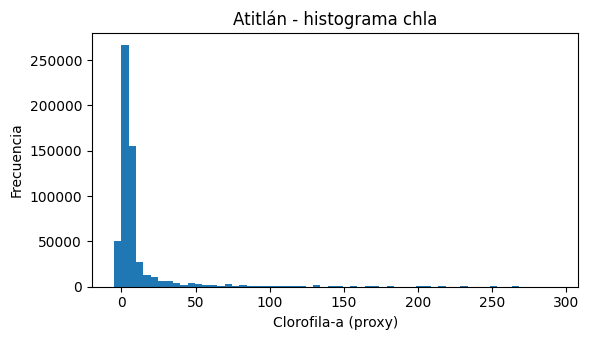

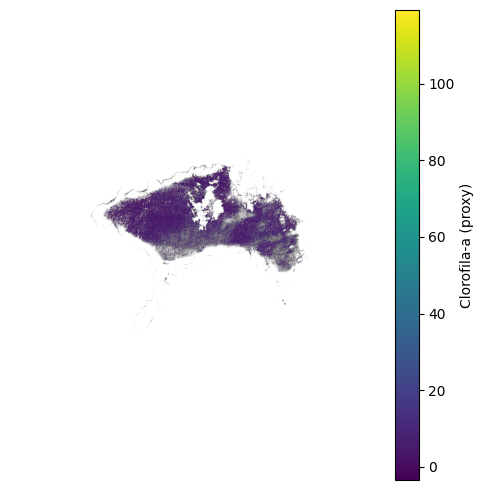

In [30]:
# QC visual (histograma y heatmap simple)

def quick_hist(tif_path, bins=60, title=None, png_out=None):
    with rasterio.open(tif_path) as src:
        a = src.read(1).astype(np.float32)
    vals = a[np.isfinite(a)]
    plt.figure(figsize=(6,3.5))
    plt.hist(vals, bins=bins)
    plt.title(title or os.path.basename(tif_path))
    plt.xlabel("Clorofila-a (proxy)"); plt.ylabel("Frecuencia")
    plt.tight_layout()
    if png_out:
        plt.savefig(png_out, dpi=140)
        plt.close()
    else:
        plt.show()

def quick_show(tif_path, png_out=None):
    with rasterio.open(tif_path) as src:
        a = src.read(1).astype(np.float32)
    vmin, vmax = np.nanpercentile(a, [2, 98])
    plt.figure(figsize=(5,5))
    plt.imshow(a, vmin=vmin, vmax=vmax)
    plt.colorbar(label="Clorofila-a (proxy)")
    plt.axis("off")
    plt.tight_layout()
    if png_out:
        plt.savefig(png_out, dpi=150)
        plt.close()
    else:
        plt.show()

if outs_ati:
    quick_hist(outs_ati[0], title="Atitlán - histograma chla")
    quick_show(outs_ati[0])
